# Node Attribute Inference (multi-class) using GraphSAGE and the Pubmed-Diabetes citation network with calibration

This notebook demonstrates probability calibration for multi-class node attribute inference. The classifier used is GraphSAGE and the dataset is the citation network Pubmed-Diabetes. Our task is to predict the subject of a paper (the nodes in the graph) that is one of 3 classes. The data are the network structure and for each paper a 500-dimensional TF/IDF word vector.

The notebook demonstrates the use of `stellargraph`'s `TemperatureCalibration` and `IsotonicCalibration` classes as well as supporting methods for calculating the Expected Calibration Error (ECE) and plotting reliability diagrams.

Since the focus of this notebook is to demonstrate the calibration of `stellargraph`'s graph neural network models for classification, we do not go into detail on the training and evaluation of said models. We suggest the reader considers the following notebook for more details on how to train and evaluate a GraphSAGE model for node attribute inference,

[Stellargraph example: GraphSAGE on the CORA citation network](https://github.com/stellargraph/stellargraph/blob/master/demos/node-classification-graphsage/graphsage-cora-node-classification-example.ipynb)

**References**
1. Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 
[cs.SI], 2017. ([link](http://snap.stanford.edu/graphsage/))

2. On Calibration of Modern Neural Networks. C. Guo, G. Pleiss, Y. Sun, and K. Q. Weinberger. 
ICML 2017. ([link](https://geoffpleiss.com/nn_calibration))

In [1]:
import networkx as nx
import pandas as pd
import os
import itertools

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import tensorflow as tf

import numpy as np

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.isotonic import IsotonicRegression

from sklearn.metrics import accuracy_score

from stellargraph import TemperatureCalibration, IsotonicCalibration
from stellargraph import plot_reliability_diagram, expected_calibration_error

In [2]:
# Given a GraphSAGE model, a node generator, and the number of predictions per point
# this method makes n_predictions number of predictions and then returns the average
# prediction for each query node.
def predict(model, node_generator, n_predictions=1):
    preds = []
    for i in range(n_predictions):
        preds.append(model.predict_generator(node_generator))
    preds_ar = np.array(preds)
    print(preds_ar.shape)
    return np.mean(preds_ar, axis=0)

### Some global parameters

In [3]:
epochs = 20  # Numper of training epochs for GraphSAGE model.
n_predictions = 5  # number of predictions per query node

### Loading the Pubmed-Diabetes network data

**Downloading the dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/Pubmed-Diabetes.tgz

The following is the description of the dataset:

> The Pubmed Diabetes dataset consists of 19717 scientific publications from PubMed database 
> pertaining to diabetes classified into one of three classes. The citation network consists 
> of 44338 links. Each publication in the dataset is described by a TF/IDF weighted word 
> vector from a dictionary which consists of 500 unique words.

Download and unzip the `Pubmed-Diabetes.tgz` file to a location on your computer.

Set the `data_dir` variable to point to the location of the dataset.

In [4]:
data_dir = "~/data/pubmed/Pubmed-Diabetes/data"

Now prepare the data so that we can create a `networkx` object that can be used by `stellargraph`.

Load the graph from edgelist

In [5]:
edgelist = pd.read_csv(
    os.path.join(data_dir, "Pubmed-Diabetes.DIRECTED.cites.tab"),
    sep="\t",
    skiprows=2,
    header=None,
)
edgelist.drop(columns=[0, 2], inplace=True)
edgelist.columns = ["source", "target"]
# delete unneccessary prefix
edgelist["source"] = edgelist["source"].map(lambda x: x.lstrip("paper:"))
edgelist["target"] = edgelist["target"].map(lambda x: x.lstrip("paper:"))
edgelist["label"] = "cites"  # set the edge type

In [6]:
edgelist.head()

,source,target,label
0,19127292,17363749,cites
1,19668377,17293876,cites
2,1313726,3002783,cites
3,19110882,14578298,cites
4,18606979,10333910,cites


In [7]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

Load the features and subject for the nodes

In [8]:
nodes_as_dict = []
with open(
    os.path.join(os.path.expanduser(data_dir), "Pubmed-Diabetes.NODE.paper.tab")
) as fp:
    for line in itertools.islice(fp, 2, None):
        line_res = line.split("\t")
        pid = line_res[0]
        feat_name = ["pid"] + [l.split("=")[0] for l in line_res[1:]][
            :-1
        ]  # delete summary
        feat_value = [l.split("=")[1] for l in line_res[1:]][:-1]  # delete summary
        feat_value = [pid] + [float(x) for x in feat_value]  # change to numeric from str
        row = dict(zip(feat_name, feat_value))
        nodes_as_dict.append(row)

# Create a Pandas dataframe holding the node data
node_data = pd.DataFrame(nodes_as_dict)
node_data.fillna(0, inplace=True)
node_data["label"] = node_data["label"].astype(int)
node_data["label"] = node_data["label"].astype(str)

In [9]:
node_data.head()

,pid,label,w-rat,w-common,w-use,w-examin,w-pathogenesi,w-retinopathi,w-mous,w-studi,...,w-kidney,w-urinari,w-myocardi,w-meal,w-ica,w-locus,w-tcell,w-depress,w-bone,w-mutat
0,12187484,1,0.093935,0.028698,0.011760,0.019375,0.063161,0.170891,0.067702,0.017555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2344352,1,0.023618,0.000000,0.014784,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14654069,1,0.102263,0.000000,0.010669,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16443886,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2684155,1,0.030616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
set(node_data["label"])

{'1', '2', '3'}

In [11]:
node_data["pid"].dtype

dtype('O')

In [12]:
node_data["pid"] = node_data.pid.astype(str)

In [13]:
node_data.index = node_data["pid"]
node_data.drop(columns=["pid"], inplace=True)
node_data.head()

,label,w-rat,w-common,w-use,w-examin,w-pathogenesi,w-retinopathi,w-mous,w-studi,w-anim,...,w-kidney,w-urinari,w-myocardi,w-meal,w-ica,w-locus,w-tcell,w-depress,w-bone,w-mutat
pid,,,,,,,,,,,,,,,,,,,,,
12187484,1,0.093935,0.028698,0.011760,0.019375,0.063161,0.170891,0.067702,0.017555,0.098402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2344352,1,0.023618,0.000000,0.014784,0.000000,0.000000,0.000000,0.000000,0.000000,0.030926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14654069,1,0.102263,0.000000,0.010669,0.000000,0.000000,0.000000,0.000000,0.000000,0.044636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16443886,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2684155,1,0.030616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [14]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=0.75, test_size=None, stratify=node_data["label"]
)
train_data, val_data = model_selection.train_test_split(
    train_data, train_size=0.75, test_size=None, stratify=train_data["label"]
)

In [15]:
train_data.shape, val_data.shape, test_data.shape

((11090, 501), (3697, 501), (4930, 501))

In [16]:
train_data.head()

,label,w-rat,w-common,w-use,w-examin,w-pathogenesi,w-retinopathi,w-mous,w-studi,w-anim,...,w-kidney,w-urinari,w-myocardi,w-meal,w-ica,w-locus,w-tcell,w-depress,w-bone,w-mutat
pid,,,,,,,,,,,,,,,,,,,,,
8650584,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.094256,0.0,0.0,0.0,0.000000
2289639,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
11269503,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.072201,0.071683,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.081169
8422766,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
15358643,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010617,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [17]:
val_data.head()

,label,w-rat,w-common,w-use,w-examin,w-pathogenesi,w-retinopathi,w-mous,w-studi,w-anim,...,w-kidney,w-urinari,w-myocardi,w-meal,w-ica,w-locus,w-tcell,w-depress,w-bone,w-mutat
pid,,,,,,,,,,,,,,,,,,,,,
1955096,1,0.093935,0.000000,0.000000,0.0,0.0,0.0,0.0,0.005852,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2569661,3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.018068,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18940401,3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.011443,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3045545,2,0.000000,0.000000,0.020907,0.0,0.0,0.0,0.0,0.005201,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16987885,3,0.000000,0.043542,0.000000,0.0,0.0,0.0,0.0,0.017756,0.037325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
test_data.head()

,label,w-rat,w-common,w-use,w-examin,w-pathogenesi,w-retinopathi,w-mous,w-studi,w-anim,...,w-kidney,w-urinari,w-myocardi,w-meal,w-ica,w-locus,w-tcell,w-depress,w-bone,w-mutat
pid,,,,,,,,,,,,,,,,,,,,,
9892239,2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.014173,0.0,...,0.0,0.000000,0.0,0.0,0.197463,0.0,0.000000,0.0,0.0,0.0
9356033,2,0.0,0.000000,0.007900,0.000000,0.0,0.160715,0.0,0.001965,0.0,...,0.0,0.012038,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
12112937,2,0.0,0.027752,0.000000,0.000000,0.0,0.000000,0.0,0.005659,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
10462137,1,0.0,0.000000,0.012469,0.041085,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2068098,1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.178213,0.0,0.0,0.0


Note using stratified sampling gives the following counts:

In [19]:
from collections import Counter

Counter(train_data["label"]), Counter(val_data["label"]), Counter(test_data["label"])

(Counter({'2': 4429, '3': 4353, '1': 2308}),
 Counter({'1': 769, '3': 1451, '2': 1477}),
 Counter({'2': 1969, '1': 1026, '3': 1935}))

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [20]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["label"]].to_dict("records"))
val_targets = target_encoding.fit_transform(val_data[["label"]].to_dict("records"))
test_targets = target_encoding.transform(test_data[["label"]].to_dict("records"))

In [21]:
train_targets

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The dataset contains attributes 'w-*' that correspond to words found in that publication.

In [22]:
node_features = node_data.drop(columns=["label"])

In [23]:
node_features.head()

,w-rat,w-common,w-use,w-examin,w-pathogenesi,w-retinopathi,w-mous,w-studi,w-anim,w-model,...,w-kidney,w-urinari,w-myocardi,w-meal,w-ica,w-locus,w-tcell,w-depress,w-bone,w-mutat
pid,,,,,,,,,,,,,,,,,,,,,
12187484,0.093935,0.028698,0.011760,0.019375,0.063161,0.170891,0.067702,0.017555,0.098402,0.062691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2344352,0.023618,0.000000,0.014784,0.000000,0.000000,0.000000,0.000000,0.000000,0.030926,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14654069,0.102263,0.000000,0.010669,0.000000,0.000000,0.000000,0.000000,0.000000,0.044636,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16443886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2684155,0.030616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080179,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [24]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [25]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44327

 Node types:
  default: [19717]
    Edge types: default-cites->default

 Edge types:
    default-cites->default: [44327]



To feed data from the graph to the Keras model we need a node generator. The node generators are specialized to the model and the learning task so we choose the `GraphSAGENodeMapper` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [26]:
batch_size = 50
num_samples = [10, 5]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [27]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

For training we map only the training nodes returned from our splitter and the target values.

In [28]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [29]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

Now we create a model to predict the 3 categories using Keras softmax layers.

In [30]:
x_inp, x_out = graphsage_model.build()
logits = layers.Dense(units=train_targets.shape[1], activation="linear")(x_out)

prediction = layers.Activation(activation="softmax")(logits)

In [31]:
prediction.shape

TensorShape([Dimension(None), Dimension(3)])

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [32]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [33]:
val_gen = generator.flow(val_data.index, val_targets)
test_gen = generator.flow(test_data.index, test_targets)

In [34]:
history = model.fit_generator(
    train_gen, epochs=epochs, validation_data=val_gen, verbose=0, shuffle=True,
)

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

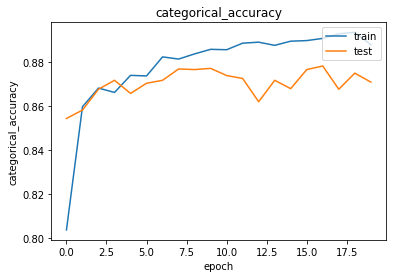

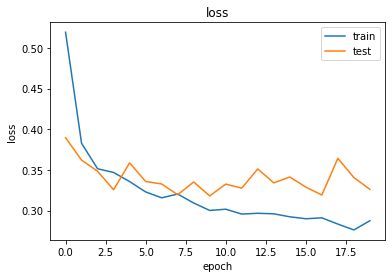

In [36]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [37]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.3190
	categorical_accuracy: 0.8864


## Calibration Curves



We want to determine if the classifier produces well-calibrated probabilities. Calibration curves also known as reliability diagrams are a visual method for this task. See reference [2] for a description of calibration curves also known as reliability diagrams.

Diagnosis of model miscalibration should be performed on a held-out dataset that was not used for training. We are going to utilise our test set for this purpose. Equivalently, we can use our validation dataset.

In [38]:
test_nodes = test_data.index
test_node_generator = generator.flow(test_nodes)

In [39]:
# test_predictions holds the model's probabilistic output predictions
test_predictions = predict(model, test_node_generator, n_predictions=n_predictions)

(5, 4930, 3)


In [40]:
# This produces a list of dictionaries (one entry per point in test set) and one entry
# in the dictionary for each class label, label=1, label=2, label=3.
y_test_pred = target_encoding.inverse_transform(test_predictions)

In [41]:
# Convert the list of dictionaries to a dataframe so that it is easier to work with the data
test_pred_results = pd.DataFrame(y_test_pred)
test_pred_results.index = test_data.index
test_pred_results.head()

,label=1,label=2,label=3
pid,,,
9892239,0.000462,0.024085,0.975453
9356033,0.000923,0.676640,0.322437
12112937,0.000848,0.927828,0.071324
10462137,0.989715,0.006866,0.003419
2068098,0.062106,0.936596,0.001298


We are going to draw one calibration curve for each column in `test_pred_results`.

In [42]:
test_pred = test_pred_results.values
test_pred.shape

(4930, 3)

In [43]:
calibration_data = []
for i in range(test_pred.shape[1]):  # iterate over classes
    calibration_data.append(
        calibration_curve(
            y_prob=test_pred[:, i], y_true=test_targets[:, i], n_bins=10, normalize=True
        )
    )

In [44]:
calibration_data[0], type(calibration_data[0])

((array([0.01121391, 0.17948718, 0.25      , 0.37333333, 0.38983051,
         0.65306122, 0.70422535, 0.66666667, 0.8487395 , 0.96449704]),
  array([0.00845599, 0.13843333, 0.25086926, 0.34645518, 0.4545375 ,
         0.54473983, 0.6550431 , 0.75446772, 0.85643066, 0.96834342])),
 tuple)

Also calculate Expected Calibration Error (ECE) for each class. See reference [2] for the definition of ECE.

In [45]:
ece = []
for i in range(test_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_data[i]
    ece.append(
        expected_calibration_error(
            prediction_probabilities=test_pred[:, i],
            accuracy=fraction_of_positives,
            confidence=mean_predicted_value,
        )
    )

In [46]:
ece

[0.008403443735250378, 0.02123280371655747, 0.018773705170920106]

Draw the reliability diagrams for each class

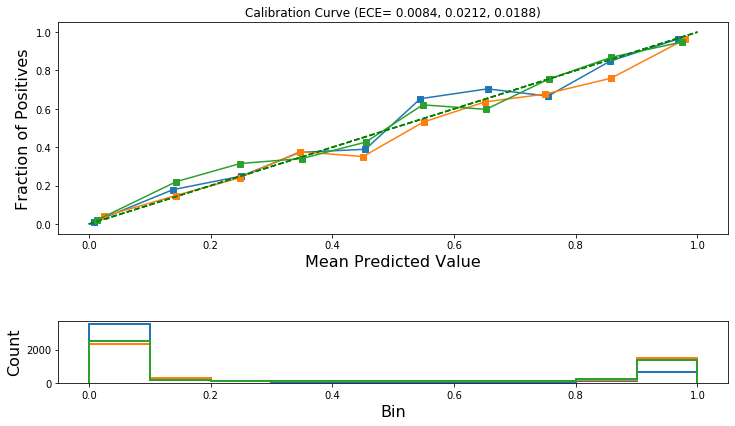

In [47]:
plot_reliability_diagram(calibration_data, test_pred, ece=ece)

## Temperature scaling calibration

Temperature scaling is an extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) for calibrating multi-class classification models. It was proposed in reference [2]. 

Temperature scaling uses a single parameter called the `temperature` to scale a classifier's non-probabilistic outputs (logits) before the application of the softmax operator that generates the model's probabilistic outputs.

$\hat{q}_i = \max\limits_{k} \sigma_{SM}(\mathbf{z}_i/T)^{(k)}$ 

where $\hat{q}_i$ is the calibrated probability for the predicted class of the i-th node; $\mathbf{z}_i$ is the vector of logits; $T$ is the temperature; $k$ is the k-th class; and, $\sigma_{SM}$ is the softmax function.

In [48]:
# this model gives the model's non-probabilistic outputs required for Temperature scaling.
score_model = Model(inputs=x_inp, outputs=logits)

Prepare the training data such that inputs are the model output logits and corresponding true class labels are the one-hot encoded.

We are going to train the calibration model on the validation dataset.

In [49]:
val_nodes = val_data.index
val_node_generator = generator.flow(val_nodes)

In [50]:
test_score_predictions = predict(
    score_model, test_node_generator, n_predictions=n_predictions
)
val_score_predictions = predict(
    score_model, val_node_generator, n_predictions=n_predictions
)

(5, 4930, 3)
(5, 3697, 3)


In [51]:
test_score_predictions.shape, val_score_predictions.shape

((4930, 3), (3697, 3))

In [52]:
x_cal_train_all = val_score_predictions
y_cal_train_all = val_targets

We are going to split the above data to a training and validation set. We are going to use the former for training the calibration model and the latter for early stopping.

In [53]:
x_cal_train, x_cal_val, y_cal_train, y_cal_val = model_selection.train_test_split(
    x_cal_train_all, y_cal_train_all
)

In [54]:
x_cal_train.shape, x_cal_val.shape, y_cal_train.shape, y_cal_val.shape

((2772, 3), (925, 3), (2772, 3), (925, 3))

Create the calibration object

In [55]:
calibration_model_temperature = TemperatureCalibration(epochs=1000)
calibration_model_temperature

Now call the `fit` method to train the calibration model.

In [56]:
calibration_model_temperature.fit(
    x_train=x_cal_train, y_train=y_cal_train, x_val=x_cal_val, y_val=y_cal_val
)

Using Early Stopping based on performance evaluated on given validation set.


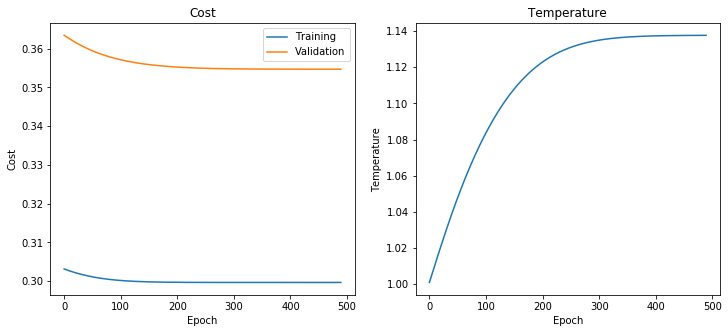

In [57]:
calibration_model_temperature.plot_training_history()

Now we can take the GraphSAGE logits, scale them by `temperature` and then apply the `softmax` to obtain the calibrated probabilities for each class.

**Note** that scaling the logits by `temperature` does not change the predictions so the model's accuracy will not change and there is no need to recalculate them.

In [58]:
test_predictions_calibrated_temperature = calibration_model_temperature.predict(
    x=test_score_predictions
)
test_predictions_calibrated_temperature.shape

(4930, 3)

Now plot the calibration curves and calculate the ECE for each class. We should expect the ECE to be lower after calibration. If not, then a different calibration method should be considered, e.g., Isotonic Regression as described later in this notebook.

In [59]:
calibration_data_after_temperature_scaling = []
for i in range(test_predictions_calibrated_temperature.shape[1]):  # iterate over classes
    calibration_data_after_temperature_scaling.append(
        calibration_curve(
            y_prob=test_predictions_calibrated_temperature[:, i],
            y_true=test_targets[:, i],
            n_bins=10,
            normalize=True,
        )
    )

In [60]:
ece_after_scaling_temperature = []
for i in range(test_predictions_calibrated_temperature.shape[1]):
    (
        fraction_of_positives,
        mean_predicted_value,
    ) = calibration_data_after_temperature_scaling[i]
    ece_after_scaling_temperature.append(
        expected_calibration_error(
            prediction_probabilities=test_predictions_calibrated_temperature[:, i],
            accuracy=fraction_of_positives,
            confidence=mean_predicted_value,
        )
    )

In [61]:
ece_after_scaling_temperature

[0.005596197989545094, 0.016018472828328516, 0.015219432744879873]

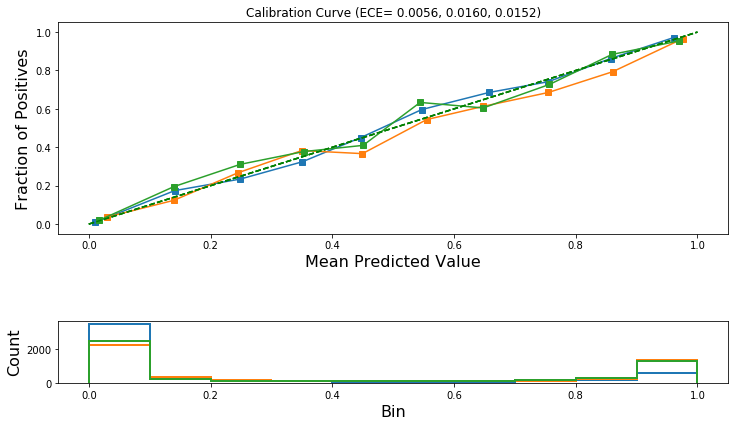

In [62]:
plot_reliability_diagram(
    calibration_data_after_temperature_scaling,
    test_predictions_calibrated_temperature,
    ece=ece_after_scaling_temperature,
)

## Isotonic Regression

We extend [Isotonic calibration](https://scikit-learn.org/stable/modules/generated/sklearn.isotonic.IsotonicRegression.html#sklearn.isotonic.IsotonicRegression) to the multi-class case by calibrating OVR models, one for each class. 

At test time, we calibrate the predictions for each class and then normalize the vector to unit norm so that the output of the calibration is a probability distribution.

**Note** that the input to the Isotonic Calibration model is the classifier's probabilistic outputs as compared to Temperature scaling where the input was the logits. 

In [63]:
test_pred.shape  # Holds the probabilistic predictions for each query node

(4930, 3)

In [64]:
# The probabilistic predictions for the validation set
val_predictions = predict(model, val_node_generator, n_predictions=n_predictions)
val_predictions.shape

(5, 3697, 3)


(3697, 3)

Create the calibration object of type `IsotonicCalibration`.

In [65]:
isotonic_calib = IsotonicCalibration()

Now call the `fit` method to train the calibraiton model.

In [66]:
isotonic_calib.fit(x_train=val_predictions, y_train=val_targets)

In [67]:
test_pred_calibrated_isotonic = isotonic_calib.predict(test_pred)
test_pred_calibrated_isotonic.shape

(4930, 3)

Now plot the calibration curves and calculate the ECE for each class. We should expect the ECE to be lower after calibration. If not, then a different calibration method should be considered, e.g., Temperature Scaling as described earlier in this notebook.

In [68]:
calibration_data_after_isotonic_scaling = []
for i in range(test_pred_calibrated_isotonic.shape[1]):  # iterate over classes
    calibration_data_after_isotonic_scaling.append(
        calibration_curve(
            y_prob=test_pred_calibrated_isotonic[:, i],
            y_true=test_targets[:, i],
            n_bins=10,
            normalize=True,
        )
    )

In [69]:
ece_after_scaling_isotonic = []
for i in range(test_pred_calibrated_isotonic.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_data_after_isotonic_scaling[
        i
    ]
    ece_after_scaling_isotonic.append(
        expected_calibration_error(
            prediction_probabilities=test_pred_calibrated_isotonic[:, i],
            accuracy=fraction_of_positives,
            confidence=mean_predicted_value,
        )
    )

In [70]:
ece_after_scaling_isotonic

[0.00954106128593478, 0.014437912501175796, 0.01765601422569558]

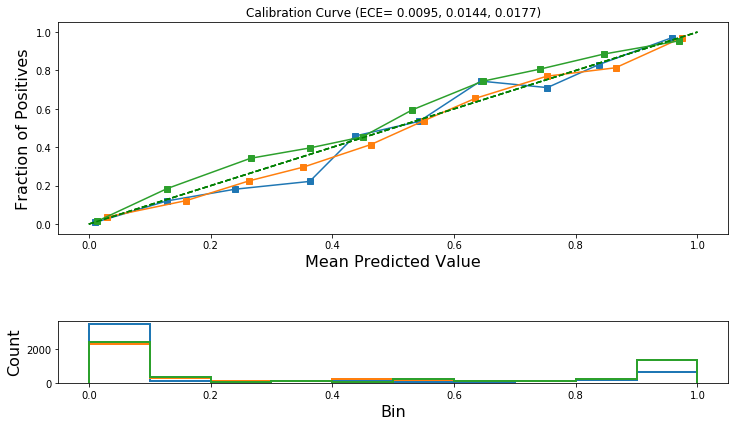

In [71]:
plot_reliability_diagram(
    calibration_data_after_isotonic_scaling,
    test_pred_calibrated_isotonic,
    ece=ece_after_scaling_isotonic,
)

### Compare ECE before and after calibration.

Let's print the ECE for the original model before calibration and for the model after calibration using Temperature Scaling and Isotonic Regression.

If model calibration is successful then either one or both of the calibrated models should have reduced ECE across all or most of the classes.

In [72]:
cal_error = ",".join(format(e, " 0.4f") for e in ece)
print("ECE before calibration:         {}".format(cal_error))
cal_error = ",".join(format(e, " 0.4f") for e in ece_after_scaling_temperature)
print("ECE after Temperature Scaling:  {}".format(cal_error))
cal_error = ",".join(format(e, " 0.4f") for e in ece_after_scaling_isotonic)
print("ECE after Isotonic Calibration: {}".format(cal_error))

ECE before calibration:          0.0084, 0.0212, 0.0188
ECE after Temperature Scaling:   0.0056, 0.0160, 0.0152
ECE after Isotonic Calibration:  0.0095, 0.0144, 0.0177


### Recalculate classifier accuracy before and after calibration

In [73]:
y_pred = np.argmax(test_pred, axis=1)
y_pred_calibrated_temperature = np.argmax(test_predictions_calibrated_temperature, axis=1)
y_pred_calibrated_isotonic = np.argmax(test_pred_calibrated_isotonic, axis=1)

In [74]:
print(
    "Accurace before calibration:         {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=np.argmax(test_targets, axis=1))
    )
)
print(
    "Accurace after Temperature Scaling:  {:.2f}".format(
        accuracy_score(
            y_pred=y_pred_calibrated_temperature, y_true=np.argmax(test_targets, axis=1)
        )
    )
)
print(
    "Accurace after Isotonic Calibration: {:.2f}".format(
        accuracy_score(
            y_pred=y_pred_calibrated_isotonic, y_true=np.argmax(test_targets, axis=1)
        )
    )
)

Accurace before calibration:         0.89
Accurace after Temperature Scaling:  0.89
Accurace after Isotonic Calibration: 0.88


## Conclusion

This notebook demonstrated how to use temperature scaling and isotonic regression to calibrate the output probabilities of a GraphSAGE model used for multi-class node attribute inference.